In [2]:
import qlat as q
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

# 24D wall source wall sink eta analysis

## Helper functions

### Jackknife

In [26]:
#Jackknife functionality

#constructs Ncf jackknife blocks
def jackblocks(data,omit,prt=0):
    #loop over timeslices
    #assuming shape (Ncf,NT)
    jacks = np.zeros(data.shape,dtype=np.complex128)
    nconf=data.shape[0]
    nt=data.shape[1]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        s=0.0
        for i in range(0,nconf):
            if i not in omit:
                s = s + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,j] = s-data[i,j]
                jacks[n,j] *= norm
                n=n+1

    return jacks
                
# jackknife blocks of size bs>=1
def jackblocks_bs(data,bs=1):
    
    jacks=np.zeros([int(data.shape[0]/bs),data.shape[1]])
    nconf=data.shape[0]
    if nconf % bs:
        print("num confs not divisible by block size")
        return
    nt=data.shape[1]
    norm=1.0/(nconf-bs)
    # loop over timeslices
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf,bs):
            jacks[n,j] = sum
            for k in range(bs):
                jacks[n,j] -= data[i+k,j]
            jacks[n,j] *= norm
            n=n+1
            
    return jacks
#
# compute avg and jacknife error from a vector of jacknife blocks
def jack(vec):
    n=vec.shape[0]
    avg=0.0
    # compute average
    for i in range(0,n):
        avg+=vec[i]
    avg = avg/n
    # compute error
    err=0.0
    for i in range(0,n):
        err+=(vec[i]-avg)*(vec[i]-avg)
    err *= (n-1)/n
    err = np.sqrt(err)
    #print(f'{n} blocks, avg+-err= {avg:.4e} +- {err:.4e}')
    return avg, err

### Fitting

In [18]:
def covariance(data, shrinkage=0.1):
    
    nconf,tsize=data.shape
    covmat=np.zeros((tsize,tsize))
    avg = np.average(data,axis=0)
    for n in range(nconf):
        covmat+=np.outer(data[n]-avg,data[n]-avg)
    covmat*=1/nconf
    covmat *= nconf-1

    #shrink toward diagonal
    diag_cov = np.diag(np.diag(covmat))
    covmat_shrunk = (1-shrinkage) * covmat + shrinkage * diag_cov
    
    return avg,covmat_shrunk

In [19]:
def meson_model(t, A0, E0):
    NT = 64
    return (A0*np.exp(-E0*t) + A0*np.exp(-(NT-t)*E0))
    #return (np.log(A0) - E0*t)

def meson_model_two_state(t, A0, E0, A1, E1):
    NT = 64
    return A0*(np.exp(-E0*t) + np.exp(-(NT-t)*E0)) + A1 * (np.exp(-E1*t) + np.exp(-(NT-t)*E1))

In [20]:
#single state meson correlator fitting function
def c2pt_fit_new(data_jk, fit_range):
    tmin, tmax = fit_range
    ncf = data_jk.shape[0]
    nt = data_jk.shape[1]
    t_fit = np.arange(tmin,tmax+1)

    corr_avg, corr_err = jack(data_jk)

    #calculate covariance matrix
    #fit of the average correlator using the average variance as sigma
    popt_avg, pcov_avg = curve_fit(meson_model,
                                  t_fit,
                                  corr_avg[tmin:tmax+1],
                                  sigma=corr_err[tmin:tmax+1],
                                  p0=[0.1,0.1],
                                  maxfev=50000)

    param_names = ['A0', 'E0']
    fit_params = {key: [] for key in param_names}
    params_jk = np.zeros((ncf,2)) #array to hold params for eahc jackknife block

    #fit of each jackknife block, no weights to generate errors
    for cf in range(ncf):
        y_data = data_jk[cf, tmin:tmax+1]
        popt, _ = curve_fit(meson_model,
                           t_fit,
                           y_data,
                           p0=popt_avg,
                           maxfev=50000)
        for key, value in zip(param_names, popt):
            fit_params[key].append(value)
        
        params_jk[cf] = popt

    fit_errors = {}
    for key in param_names:
        vals = np.array(fit_params[key])
        mean_val, err_val = jack(vals)
        fit_errors[key] = err_val

    #calculate chi squared
    corr_model = meson_model(t_fit, *popt_avg)
    residuals = corr_avg[tmin:tmax+1] - corr_model
    chi2 = np.sum((residuals / np.std(residuals))**2)
    dof = len(t_fit) - 2
    chi2_dof = chi2/dof

    #covariance matrix
    params_cov = np.cov(params_jk.T) * (ncf - 1)

    return popt_avg,fit_errors,fit_params,chi2_dof

In [21]:
def meson_energy_new(data_jk, tmin, tmax):
    fit_range = (tmin, tmax)
    popt_avg, fit_errors, fit_params, chi2_dof = c2pt_fit_new(data_jk, fit_range)
    E0 = popt_avg[1]
    E0_err = fit_errors['E0']
    E0_block = fit_params['E0']
    A0 = popt_avg[0]
    A0_err = fit_errors['A0']
    A0_block = fit_params['A0']
    
    return E0, E0_err, chi2_dof

In [22]:
#two state meson correlator fit
def c2pt_fit_2state(data_jk, fit_range):
    tmin,tmax = fit_range
    npar = 4 # A0, E0, A1, E1
    guess = ([0.2,0.2,0.2,0.2])
    ncf = data_jk.shape[0]
    t_fit = np.arange(tmin, tmax+1)
    csq = np.zeros((ncf))
    corr_avg,corr_err = jack(data_jk)

    dof = tmax - tmin - npar

    popt_avg, pcov_avg = curve_fit(meson_model_two_state,
                              t_fit,
                              corr_avg[tmin:tmax+1],
                              sigma=corr_err[tmin:tmax+1],
                              p0=guess,
                              maxfev=50000)

    param_names = ['A0', 'E0', 'A1', 'E1']
    fit_params = {key: [] for key in param_names}
    params_jk = np.zeros((ncf, npar))

    #fit each jk block
    for jk in range(ncf):
        y_data = data_jk[jk, tmin:tmax+1]
        popt, _  = curve_fit(meson_model_two_state, 
                            t_fit, 
                            y_data,
                            p0 = popt_avg,
                            maxfev=50000)
        for key,value in zip(param_names, popt):
            fit_params[key].append(value)

        params_jk[jk] = popt
        
    fit_errors = {}
    for key in param_names:
        vals = np.array(fit_params[key])
        mean_val, err_val = jack(vals)
        fit_errors[key] = err_val

    theory = meson_model_two_state(t_fit, *popt_avg)
    residuals = corr_avg[tmin:tmax+1] - theory
    chi2 = np.sum((residuals / corr_err[tmin:tmax+1])**2)
    dof = len(t_fit) - npar
    chi2_dof = chi2/dof
    
    F = fdist(dof,ncf-dof)
    p_value = 1 - stats.chi2(dof).cdf(chi2)
    #print('n, chi square, dof=',chi2,dof)
    #print('p-value=',p_value)
    #print("----------------------------------------")

    return popt_avg, fit_errors, fit_params, p_value, chi2_dof

In [23]:
def meson_energy_2state(data_jk, tmin, tmax):
    fit_range = (tmin, tmax)
    popt_avg, fit_errors, fit_params, p_value, chi2_dof = c2pt_fit_2state(data_jk, fit_range)
    
    A0 = popt_avg[0]
    A0_err = fit_errors['A0']
    A0_block = fit_params['A0']

    E0 = popt_avg[1]
    E0_err = fit_errors['E0']
    E0_block = fit_params['E0']

    A1 = popt_avg[2]
    A1_err = fit_errors['A1']
    A1_block = fit_params['A1']

    E1 = popt_avg[3]
    E1_err = fit_errors['E1']
    E1_block = fit_params['E1']
    
    return A0, A0_err, E0, E0_err, A1, A1_err, E1, E1_err, p_value, chi2_dof

### Effective mass

In [24]:
# cosh effective mass
#effective mass calculation using two data points/log definition. This uses only one half of the correlator data. This is for the one term fit function

def eff_mass_2d_cosh_half(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        for t in range(nt-2):
            E = np.arccosh((corr_data[cf,t] + corr_data[cf,t+2])/(2*corr_data[cf,t+1]))
            print(E)
            m_data[cf,t] = E

    return m_data

#Effective mass calculation using three data points and the arccosh definition. This folds the correlator, and uses two data points per measurement
#this is to be used with the two term fit function
def eff_mass_2d_cosh(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt//2-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        #fold correlator
        C_fold = np.zeros(nt//2 + 1,np.float64)

        C_fold[0] = corr_data[cf,0]
        C_fold[nt//2] = corr_data[cf,nt//2]
        for t in range(1,nt//2):
            C_fold[t] = (corr_data[cf,t] + corr_data[cf,nt-t])/2 
        
        for t in range(nt//2-2):
            E = np.arccosh((C_fold[t] + C_fold[t+2])/(2*C_fold[t+1]))
            m_data[cf,t] = E

    return m_data

In [25]:
def eff_mass_2d_ln_half(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        for t in range(nt-2):
        #E = np.arccosh((C_fold[t] + C_fold[t+2])/(2*C_fold[t+1]))
            E = np.log(corr_data[cf,t]/corr_data[cf,t+1])
            m_data[cf,t] = E

    return m_data

#effective mass calculation using two data points/log definition. This uses only one half of the correlator data. This is for the one term fit function
def eff_mass_2d_ln(corr_data):
    ncf = corr_data.shape[0]
    nt = corr_data.shape[1]
    m_data = np.zeros((ncf, nt//2-2),np.float64)
    E = 0.0
    for cf in range(ncf):
        #fold correlator
        C_fold = np.zeros(nt//2 + 1,np.float64)

        C_fold[0] = corr_data[cf,0]
        C_fold[nt//2] = corr_data[cf,nt//2]
        for t in range(1,nt//2):
            C_fold[t] = (corr_data[cf,t] + corr_data[cf,nt-t])/2 
        
        for t in range(nt//2-2):
        #E = np.arccosh((C_fold[t] + C_fold[t+2])/(2*C_fold[t+1]))
            #E = np.log(corr_data[cf,t]/corr_data[cf,t+1])
            E = np.log(C_fold[t]/C_fold[t+1])
            m_data[cf,t] = E

    return m_data

## Load data

In [3]:
dst_4030 = "/home/jhildebrand28/ktopipi/results/24D/auto-contract/traj-4030/meson_corr_c.lat"
ld4030 = q.load_lat_data(dst_4030)
q.display_info(ld4030.info())

[['expr_name', 3, ['< 1 >  exprs[0]', '< light_meson^dag(0) * light_meson(-tsep) >  exprs[1]', '< strage_meson^dag(0) * strange_meson(-tsep) >  exprs[2]']], ['t_sep', 64, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '-32', '-31', '-30', '-29', '-28', '-27', '-26', '-25', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1']]]

In [111]:
arr = ld4030.to_numpy()
arr.shape

(3, 64)

In [113]:
strange_corr = arr[2,:]

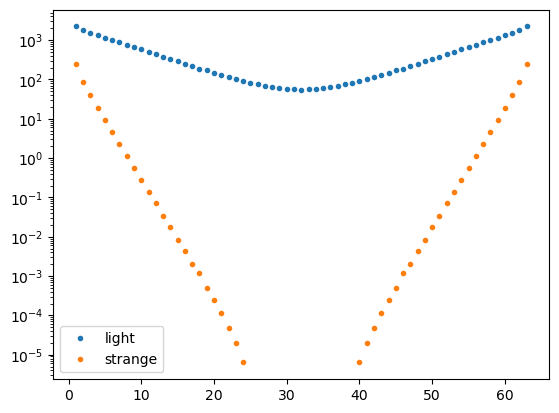

In [114]:
t0 = np.linspace(1,63,63)
fig0, ax0 = plt.subplots()
ax0.plot(t0,arr[1,1:].real/(48*48*48),marker='.', ls='',label='light')
ax0.plot(t0,arr[2,1:].real/(48*48*48),marker='.', ls='',label='strange')
ax0.set_yscale("log")
ax0.legend();

In [73]:
dst_list = []
dst_list_2 = []
prefix1 = "/home/jhildebrand28/ktopipi/results/24D/auto-contract-conn/"
prefix2 = "/home/jhildebrand28/ktopipi/results/24D/auto-contract/"

for i in range(4030,5021,10):
    dst_list.append(prefix1+f"traj-{i}/meson_corr_c.lat")
    dst_list_2.append(prefix2+f"traj-{i}/meson_corr_dc.lat")
    

In [78]:
ncf = len(dst_list)
allconf_conn = []
allconf_dc = []
for i in range(ncf):
    allconf_conn.append(q.load_lat_data(dst_list[i]).to_numpy())
    allconf_dc.append(q.load_lat_data(dst_list_2[i]).to_numpy())

full_arr_c = np.array(allconf_conn)
full_arr_dc = np.array(allconf_dc)
full_arr_dc.shape

(100, 5, 64)

In [79]:
#class to hold some very used parameters
class eta_conn_24D:
    def __init__(self, jks_light, jks_strange):
        self.ncf = jks_light.shape[0]
        self.nt = jks_strange.shape[1]
        self.corr_range = np.linspace(0,self.nt-1,self.nt)
        self.jks_l = jks_light
        self.jks_s = jks_strange
        self.a_inv = 1.023
        pass

## Connected piece

In [28]:
Cl_jk = jackblocks(full_arr[:,1,:],omit=[])
Cs_jk = jackblocks(full_arr[:,2,:],omit=[])

conn = eta_conn_24D(Cl_jk, Cs_jk)

In [32]:
Cl_avg, Cl_err = jack(Cl_jk.real)
Cs_avg, Cs_err = jack(Cs_jk.real)

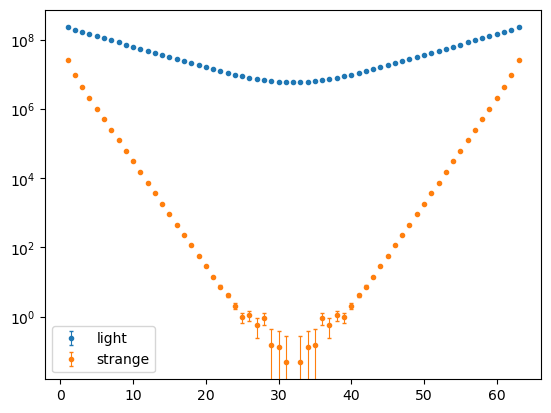

In [34]:
fig1,ax1 = plt.subplots()
ax1.errorbar(conn.corr_range[1:],Cl_avg[1:],yerr=Cl_err[1:],marker='.',ls='',elinewidth=0.8,capsize=1.5,label='light')
ax1.errorbar(conn.corr_range[1:],Cs_avg[1:],yerr=Cs_err[1:],marker='.',ls='',elinewidth=0.8,capsize=1.5,label='strange')
ax1.set_yscale("log")
ax1.legend();

In [29]:
#construct the connected parts of the correlator
'''
eta = 1/sqrt(6) (ubar u + dbar d - 2*sbar s)
eta_prime = 1/sqrt(3) (ubar u + dbar d + sbar s)

=> <eta eta^dag> = 1/6 * (Cl + 4*Cs)
=> <eta' eta'^dag> = 1/3 * (Cl + Cs)
'''
#for the connected piece we can just construct these here with the light and strange meson contractions
eta_jk = np.zeros((ncf,nt),dtype=np.complex128)
etap_jk = np.zeros((ncf,nt),dtype=np.complex128)

eta_jk = (1/6) * (conn.jks_l + 4*conn.jks_s)
etap_jk = (1/3) * (conn.jks_l + conn.jks_s)

eta_jk.shape

(100, 64)

In [35]:
eta_avg, eta_err = jack(eta_jk)
etap_avg, etap_err = jack(etap_jk)

In [119]:
eta_avg[1:48]/(48*48*48)

array([540.72207272-7.01584093e-04j, 361.73128093+4.95532464e-04j,
       288.80609689-4.85971492e-04j, 240.16840865+2.15119472e-04j,
       203.97693777-2.03190841e-04j, 174.81218222-2.60957219e-04j,
       150.88078697-3.86761956e-04j, 130.78347183-1.37777458e-04j,
       113.25925067-2.96147991e-04j,  98.43285798-2.99878795e-04j,
        85.5299165 -3.42293963e-05j,  74.38254739+1.51988611e-04j,
        64.79693863-6.41311846e-05j,  56.37362864-3.33289380e-05j,
        49.08503623-6.90815158e-05j,  42.79165075-7.77385424e-05j,
        37.36665391+2.46940277e-05j,  32.62461432-1.79466794e-04j,
        28.66031389-1.04481423e-04j,  25.05659943+3.22885471e-05j,
        22.01542058-7.55162986e-05j,  19.39059702+4.64148549e-06j,
        17.21709328-3.19478461e-05j,  15.32117233+7.73154848e-06j,
        13.73365934+6.10051398e-05j,  12.38420198+4.74771024e-05j,
        11.31253588-1.40362816e-05j,  10.47592696-5.95250030e-05j,
         9.83277656+4.85678228e-06j,   9.37180858+3.64178510e-

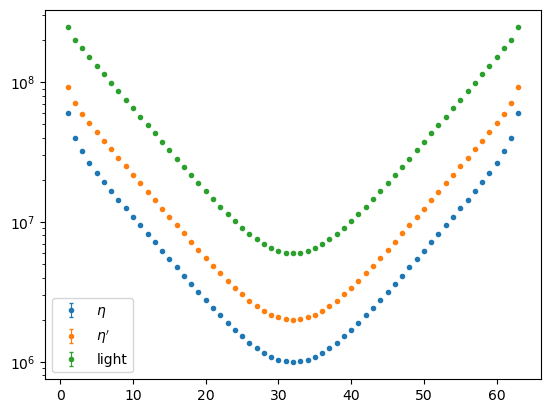

In [102]:
fig2, ax2 = plt.subplots()
ax2.errorbar(conn.corr_range[1:],eta_avg[1:],yerr=eta_err[1:],marker='.',ls='',elinewidth=0.8,capsize=1.5,label=r"$\eta$")
ax2.errorbar(conn.corr_range[1:],etap_avg[1:],yerr=etap_err[1:],marker='.',ls='',elinewidth=0.8,capsize=1.5,label=r"$\eta '$")
ax2.errorbar(conn.corr_range[1:],Cl_avg[1:],yerr=Cl_err[1:],marker='.',ls='',elinewidth=0.8,capsize=1.5,label=r"light")
ax2.set_yscale("log")
ax2.legend();

In [103]:
t_em = 30
em_eta_jks = np.zeros((conn.ncf, conn.nt-2))
em_eta_prime_jks = np.zeros((conn.ncf, conn.nt-2))
em_light_jks = np.zeros((conn.ncf, conn.nt-2))

em_eta_jks = eff_mass_2d_cosh(eta_jk.real)
em_eta_prime_jks = eff_mass_2d_cosh(etap_jk.real)
em_light_jks = eff_mass_2d_cosh(Cl_jk.real)


em_eta_avg, em_eta_err = jack(em_eta_jks)
em_eta_prime_avg, em_eta_prime_err = jack(em_eta_prime_jks)
em_light_avg, em_light_err = jack(em_light_jks)

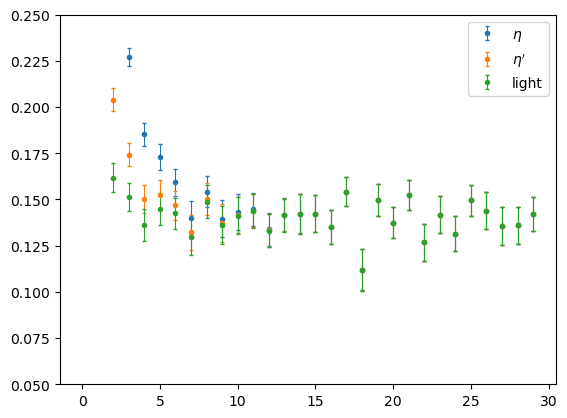

In [104]:
t_em_range = np.linspace(0,t_em-1,t_em)
fig2, ax2 = plt.subplots()
ax2.errorbar(t_em_range, em_eta_avg, yerr = em_eta_err, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\eta$")
ax2.errorbar(t_em_range, em_eta_prime_avg, yerr = em_eta_prime_err, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\eta'$")
ax2.errorbar(t_em_range, em_light_avg, yerr = em_light_err, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"light")
ax2.set_ylim(0.05,0.25)
ax2.legend()

In [54]:
em_eta_avg.shape

(30,)

In [108]:
E_eta, E_eta_err, chi_dof_eta = meson_energy_new(eta_jk.real,10,30)
E_eta_p, E_eta_p_err, chi_dof_eta_p = meson_energy_new(etap_jk.real,10,30)
#E_light, E_light_err, chi_dof_light = meson_energy_new(Cl_jk.real,10,30)

In [107]:
print(f"E_eta = {-E_eta} +/ {E_eta_err}$")
print(f"E_eta_prime = {-E_eta_p} +/ {E_eta_p_err}$")
#print(f"E_light = {-E_light} +/ {E_light_err}$")

E_eta = 0.13996054280078962 +/ 0.00027282291877497465$
E_eta_prime = 0.1399145379137128 +/ 0.000272332555267544$


In [95]:
print(f"E_eta  = {-E_eta:.5f}(27)")
print(f"E_eta' = {-E_eta_p:.5f}(27)")

E_eta  = 0.13996(27)
E_eta' = 0.13991(27)


## Disconnected piece

In [80]:
class eta_disconn_24D:
    def __init__(self,jks_88, jks_11):
        self.nOp = 2
        self.ncf = jks_88.shape[0]
        self.nt = jks_88.shape[1]
        self.corr_range = np.linspace(0,self.nt-1,self.nt)
        self.jks88 = jks_88
        self.jks11 = jks_11
        pass

In [65]:
dst_5030 = "/home/jhildebrand28/ktopipi/results/24D/auto-contract/traj-5030/meson_corr_dc.lat"
ld5030 = q.load_lat_data(dst_5030)
q.display_info(ld5030.info())
arr5030 = ld5030.to_numpy()
print(arr5030.shape)

[['expr_name', 5, ['< 1 >  exprs[0]', '< eta_dag(0) * eta(-tsep) > (Type2)  exprs[1]', '< eta_prime^dag(0) * eta_prime(-tsep) > (Type2)  exprs[2]', '< eta_dag(0) * eta_prime(-tsep) > (Type2)  exprs[3]', '< eta_prime^dag(0) * eta(-tsep) > (Type2)  exprs[4]']], ['t_sep', 64, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '-32', '-31', '-30', '-29', '-28', '-27', '-26', '-25', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1']]](5, 64)


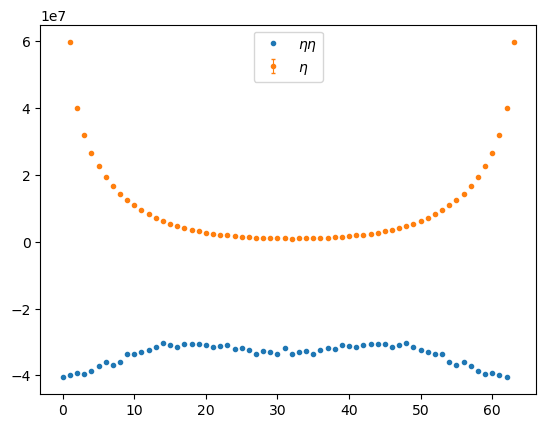

In [145]:
t0 = np.linspace(0,62,63)
fig4, ax4 = plt.subplots()
ax4.plot(t0, arr5030[1,1:].real,marker='.',ls='',label=r"$\eta \eta$")
ax4.errorbar(conn.corr_range[1:],eta_avg[1:],yerr=eta_err[1:],marker='.',ls='',elinewidth=0.8,capsize=1.5,label=r"$\eta$")
#ax4.plot(t0, arr5030[2,1:].real,marker='.',ls='',label=r"$\eta ' \eta '$")
#ax4.plot(t0, arr5030[3,1:].real,marker='.',ls='',label=r"$\eta \eta '$")
#ax4.plot(t0, arr5030[4,1:].real,marker='.',ls='',label=r"$\eta ' \eta$")
#ax4.set_yscale("log")
ax4.legend()

In [83]:
eta_eta_jks = jackblocks(full_arr_dc[:,1,:],omit=[])
etap_etap_jks = jackblocks(full_arr_dc[:,2,:],omit=[])

eta_eta_avg, eta_eta_err = jack(eta_eta_jks)
etap_etap_avg, etap_etap_err = jack(etap_etap_jks)

In [158]:
V = 48*48*48

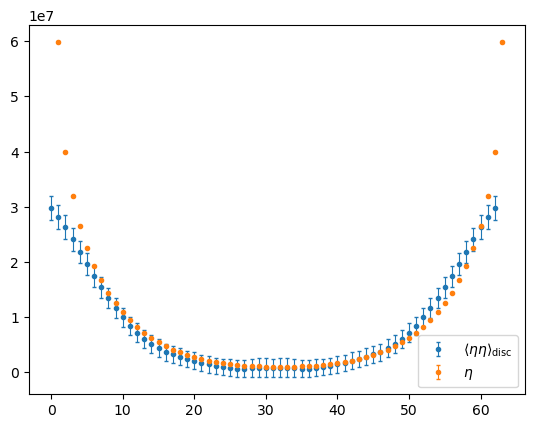

In [156]:
fig5, ax5 = plt.subplots()
ax5.errorbar(t0, -eta_eta_avg[1:], yerr=eta_eta_err[1:], marker='.', ls='', elinewidth=0.8, capsize=1.5,label=r"$\langle\eta \eta\rangle_{\text{disc}}$")
#ax5.errorbar(t0, etap_etap_avg[1:], yerr=etap_etap_err[1:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle\eta' \eta'\rangle_{\text{disc}}$")
ax5.errorbar(conn.corr_range[1:],eta_avg[1:],yerr=eta_err[1:],marker='.',ls='',elinewidth=0.8,capsize=1.5,label=r"$\eta$")
#ax5.set_yscale("log")
ax5.legend();

In [162]:
eta_eta_avg[:32]/(V)

array([-310.0917502 +0.00071617j, -269.05729136+0.00075141j,
       -255.05830382+0.00130943j, -237.83122836-0.00017679j,
       -218.14499894+0.00038861j, -197.28757418+0.00042656j,
       -177.34257445+0.00149046j, -157.43903596+0.0004264j ,
       -139.26213192+0.00019279j, -121.40302784+0.00161118j,
       -105.52676646+0.00204865j,  -90.14342563+0.00209131j,
        -76.14274538+0.00126749j,  -65.29524871+0.00218669j,
        -55.42056085+0.00107363j,  -46.38143291+0.0006507j ,
        -39.87828527+0.00117712j,  -33.03478065+0.00122971j,
        -29.6635078 +0.00228642j,  -25.60236844-0.00010892j,
        -21.84562637+0.00151285j,  -19.44700423+0.0003952j ,
        -15.17502151+0.0001414j ,  -12.99265499-0.00051366j,
        -10.18958527-0.00108865j,   -9.13446316-0.00018605j,
         -7.95799486-0.00121951j,   -6.04051633-0.00046508j,
         -6.21738891-0.00136197j,   -7.18070143-0.00086196j,
         -7.83441193-0.00127215j,   -7.82872976-0.00205602j])

In [160]:
eta_avg[:32]/V

array([3133.92699458+1.71633414e-03j,  540.72207272-7.01584093e-04j,
        361.73128093+4.95532464e-04j,  288.80609689-4.85971492e-04j,
        240.16840865+2.15119472e-04j,  203.97693777-2.03190841e-04j,
        174.81218222-2.60957219e-04j,  150.88078697-3.86761956e-04j,
        130.78347183-1.37777458e-04j,  113.25925067-2.96147991e-04j,
         98.43285798-2.99878795e-04j,   85.5299165 -3.42293963e-05j,
         74.38254739+1.51988611e-04j,   64.79693863-6.41311846e-05j,
         56.37362864-3.33289380e-05j,   49.08503623-6.90815158e-05j,
         42.79165075-7.77385424e-05j,   37.36665391+2.46940277e-05j,
         32.62461432-1.79466794e-04j,   28.66031389-1.04481423e-04j,
         25.05659943+3.22885471e-05j,   22.01542058-7.55162986e-05j,
         19.39059702+4.64148549e-06j,   17.21709328-3.19478461e-05j,
         15.32117233+7.73154848e-06j,   13.73365934+6.10051398e-05j,
         12.38420198+4.74771024e-05j,   11.31253588-1.40362816e-05j,
         10.47592696-5.95250030e-0

In [157]:
eta_avg[:32]/eta_eta_avg[:32]

array([-10.10645073-2.88762232e-05j,  -2.00969121-3.00499247e-06j,
        -1.41822978-9.22377916e-06j,  -1.21433211+2.94602409e-06j,
        -1.10095766-2.94739439e-06j,  -1.03390666-1.20549320e-06j,
        -0.98573161-6.81298323e-06j,  -0.9583442 -1.38953017e-07j,
        -0.93911726-3.10760335e-07j,  -0.93291949-9.94169123e-06j,
        -0.93277622-1.52667949e-05j,  -0.94882035-2.16327352e-05j,
        -0.97688292-1.82575588e-05j,  -0.99236836-3.22515737e-05j,
        -1.01719701-1.91041641e-05j,  -1.05829064-1.33576339e-05j,
        -1.07305644-2.97247863e-05j,  -1.13113068-4.28534956e-05j,
        -1.0998232 -7.87228322e-05j,  -1.11943994+8.84331034e-06j,
        -1.1469847 -8.09087560e-05j,  -1.1320726 -1.91224849e-05j,
        -1.277797  -1.22126169e-05j,  -1.32514049+5.48480868e-05j,
        -1.50361097+1.59886420e-04j,  -1.50349934+2.39449282e-05j,
        -1.55619624+2.32510973e-04j,  -1.8727763 +1.46514587e-04j,
        -1.68493987+3.78672907e-04j,  -1.3693337 +1.63695355e-

In [82]:
disc = eta_disconn_24D(eta_eta_jks, etap_etap_jks)

In [97]:
eta_eta_jks.shape

(100, 64)

In [122]:
dst_1605 = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-sigma/traj-1605/meson_corr.lat"
ld1605 = q.load_lat_data(dst_1605)
q.display_info(ld1605.info())

[['expr_name', 4, ['< 1 >  exprs[0]', '< sigma^dag(0) * sigma(-tsep) > (Type1)  exprs[1]', '< sigma^dag(0) * sigma(-tsep) > (Type2)  exprs[2]', '< sigma^dag(0) * sigma(-tsep) >  exprs[3]']], ['t_sep', 96, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '-48', '-47', '-46', '-45', '-44', '-43', '-42', '-41', '-40', '-39', '-38', '-37', '-36', '-35', '-34', '-33', '-32', '-31', '-30', '-29', '-28', '-27', '-26', '-25', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1']]]

In [124]:
arr1605 = ld1605.to_numpy()
arr1605.shape

(4, 96)

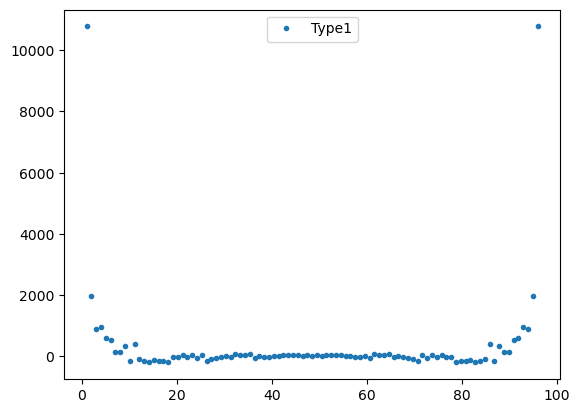

In [168]:
t0 = np.linspace(1,96,95)
fig0, ax0 = plt.subplots()
ax0.plot(t0,arr1605[1,1:].real/(48*48*48),marker='.', ls='',label='Type1')
#ax0.plot(t0,arr1605[2,1:].real/((48*48*48)**2),marker='.', ls='',label='Type2')
#ax0.plot(t0,arr1605[3,1:].real,marker='.', ls='',label='Total')
#ax0.set_yscale("log")
#ax0.set_ylim(2e6,3e6)
ax0.legend();

In [135]:
arr1605[2,:48]/arr1605[1,:48]

array([-2.44505715e+01+8.50009975e-04j,  2.07219741e+02-9.19730635e-02j,
        1.12800204e+03+1.00669345e-01j,  2.50387348e+03+4.94971578e+00j,
        2.37206282e+03-5.12478172e+00j,  3.80361415e+03+1.10961832e+01j,
        4.27442037e+03-1.03962334e+01j,  1.53588912e+04+1.64826654e+02j,
        1.65279697e+04-3.23511598e+02j,  6.80914873e+03+7.06606237e+01j,
       -1.44860675e+04-7.80530763e+01j,  5.48522584e+03+1.77855663e+01j,
       -2.82127660e+04+9.48552241e+02j, -1.59196865e+04-1.60846068e+02j,
       -1.30493415e+04+7.75051680e+01j, -1.62785856e+04-8.74499891e+01j,
       -1.51114018e+04+1.15979165e+02j, -1.33682481e+04-1.05113109e+02j,
       -1.10297149e+04+4.10901317e+01j, -1.47851135e+05+1.30684008e+04j,
       -8.20163291e+04+9.94237720e+02j,  7.68367196e+04+2.65129451e+03j,
       -8.75415593e+04+1.32344655e+03j,  7.56409190e+04+6.44488149e+02j,
       -4.74915980e+04+1.82061376e+01j,  6.01434433e+04-6.20260668e+02j,
       -1.43568338e+04-6.32154967e+01j, -2.28007858

TypeError: 'int' object is not iterable